# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Logística

### Import required libraries and dataset

In [40]:
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
from os.path import exists

In [41]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [42]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Download and load Fashion MNIST dataset

In [43]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

### Normalize the dataset

In [44]:
data_max = np.max(train_X)
train_X = train_X.astype('float32') / data_max
test_X = test_X.astype('float32') / data_max
np.max(train_X)

1.0

#### Example: Show the first object of the train dataset

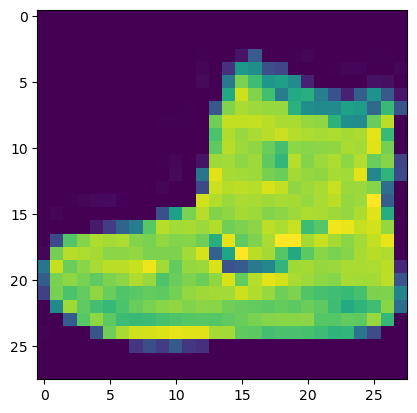

In [45]:
plt.imshow(train_X[0,...])

### Convert the dataset from a vector form to a categorical distribution

In [46]:
num_classes = np.max(train_y) + 1
train_y = utils.to_categorical(train_y, num_classes)
test_y = utils.to_categorical(test_y, num_classes)

### Config the model to be trained

#### Softmax

In [47]:
#train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32')
#test_X = test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32')

In [48]:
model =  Sequential()
#model.add(preprocessing.RandomFlip("horizontal", input_shape=(28,28,1)))
model.add(layers.Dropout(0.1, input_shape=(28,28)))
model.add(layers.Flatten(input_shape=(28,28)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 28, 28)            0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### MLP

In [49]:
# TODO

### Compile the model

In [50]:
model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=0.0002, momentum=0.95),metrics=["accuracy"])

In [51]:
# Callback to stop training if, after 2 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [52]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [53]:
# Logs and metrics from TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Fit the model to the train data and validate it with the test data

In [54]:
# We load the previously best weights to save time on training
if (exists(checkpoint_filepath)):
    model.load_weights(checkpoint_filepath)

In [55]:
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

2023-05-21 11:06:39.990465: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
938/938 [==============================] - 6s 7ms/step - loss: 1.2186 - accuracy: 0.6225 - val_loss: 0.8336 - val_accuracy: 0.7239
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.7530 - accuracy: 0.7531 - val_loss: 0.6909 - val_accuracy: 0.7716
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6572 - accuracy: 0.7834 - val_loss: 0.6277 - val_accuracy: 0.7903
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6082 - accuracy: 0.7974 - val_loss: 0.5921 - val_accuracy: 0.8023
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.5756 - accuracy: 0.8069 - val_loss: 0.5651 - val_accuracy: 0.8103
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.5540 - accuracy: 0.8128 - val_loss: 0.5481 - val_accuracy: 0.8132
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.5357 - accuracy: 0.8186 - val_loss: 0.5336 - val_accuracy: 0.8188
Epoch 

### Plot important metrics

#### TensorBoard session

In [56]:
%tensorboard --logdir logs/fit

#### Loss

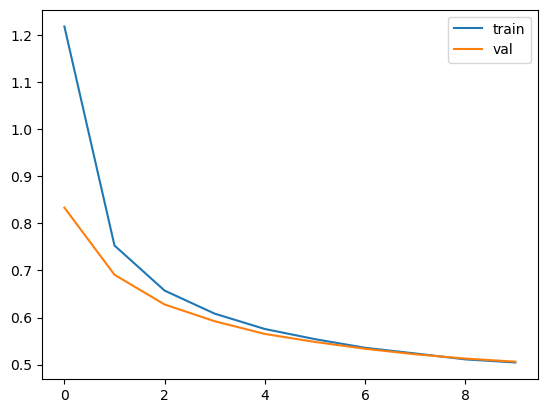

In [57]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

#### Accuracy

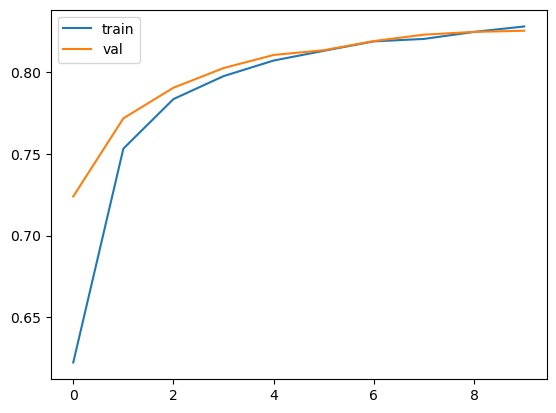

In [58]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()